In [0]:
import os

In [2]:
cd /content/

/content


In [3]:
!mkdir train
!mkdir test
!mkdir checkpoint

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘checkpoint’: File exists


In [4]:
os.listdir()

['.config',
 'train',
 'Ranger-Deep-Learning-Optimizer',
 'sample_submission.csv',
 'test',
 'checkpoint',
 'test.zip',
 'train.zip',
 'sample_data']

In [5]:
!unzip test.zip -d test

Streaming output truncated to the last 5000 lines.
  inflating: test/Test/1576.jpg      
  inflating: test/Test/15762.jpg     
  inflating: test/Test/15765.jpg     
  inflating: test/Test/15768.jpg     
  inflating: test/Test/15770.jpg     
  inflating: test/Test/15773.jpg     
  inflating: test/Test/15778.jpg     
  inflating: test/Test/15780.jpg     
  inflating: test/Test/15784.jpg     
  inflating: test/Test/15803.jpg     
  inflating: test/Test/15805.jpg     
  inflating: test/Test/15806.jpg     
  inflating: test/Test/15808.jpg     
  inflating: test/Test/1581.jpg      
  inflating: test/Test/15810.jpg     
  inflating: test/Test/15811.jpg     
  inflating: test/Test/15812.jpg     
  inflating: test/Test/15813.jpg     
  inflating: test/Test/15814.jpg     
  inflating: test/Test/15815.jpg     
  inflating: test/Test/15824.jpg     
  inflating: test/Test/15825.jpg     
  inflating: test/Test/15827.jpg     
  inflating: test/Test/15831.jpg     
  inflating: test/Test/15833.jpg     

In [6]:
!unzip train.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/Train/4047.jpg    
  inflating: train/Train/4049.jpg    
  inflating: train/Train/405.jpg     
  inflating: train/Train/4051.jpg    
  inflating: train/Train/4052.jpg    
  inflating: train/Train/4053.jpg    
  inflating: train/Train/4055.jpg    
  inflating: train/Train/4056.jpg    
  inflating: train/Train/4057.jpg    
  inflating: train/Train/4058.jpg    
  inflating: train/Train/4059.jpg    
  inflating: train/Train/406.jpg     
  inflating: train/Train/4060.jpg    
  inflating: train/Train/4061.jpg    
  inflating: train/Train/4062.jpg    
  inflating: train/Train/4065.jpg    
  inflating: train/Train/4066.jpg    
  inflating: train/Train/4068.jpg    
  inflating: train/Train/4069.jpg    
  inflating: train/Train/407.jpg     
  inflating: train/Train/4070.jpg    
  inflating: train/Train/4072.jpg    
  inflating: train/Train/4073.jpg    
  inflating: train/Train/4076.jpg    
  inflating: train/Train/4078.jpg    

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import time
import pandas as pd
from PIL import Image
from skimage import io
import glob
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OPTIMIZERS

ranger implementation error


In [5]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
!cd Ranger-Deep-Learning-Optimizer


fatal: destination path 'Ranger-Deep-Learning-Optimizer' already exists and is not an empty directory.


In [6]:
!pip install ranger


used 0ver9000

In [0]:
import torch, math
from torch.optim.optimizer import Optimizer

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# Lookahead implementation from https://github.com/rwightman/pytorch-image-models/blob/master/timm/optim/lookahead.py

""" Lookahead Optimizer Wrapper.
Implementation modified from: https://github.com/alphadl/lookahead.pytorch
Paper: `Lookahead Optimizer: k steps forward, 1 step back` - https://arxiv.org/abs/1907.08610
"""
import torch
from torch.optim.optimizer import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)

def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
     adam = Adam(params, *args, **kwargs)
     return Lookahead(adam, alpha, k)


# RAdam + LARS + LookAHead

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
# RAdam + LARS implementation from https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20

def Over9000(params, alpha=0.5, k=5, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

RangerLars = Over9000 

In [9]:
sample_submission=pd.read_csv('sample_submission.csv')
sample_submission.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [10]:
df_train=pd.read_csv('train/train.csv')
df1 = df_train['Class']
df2 = df_train["ID"]
df1 = pd.get_dummies(df1)
df = pd.concat([df2,df1], axis=1)
df.head()

,ID,MIDDLE,OLD,YOUNG
0,377.jpg,1,0,0
1,17814.jpg,0,0,1
2,21283.jpg,1,0,0
3,16496.jpg,0,0,1
4,4487.jpg,1,0,0


In [11]:
columns_titles = ['ID',"YOUNG","MIDDLE",'OLD']

df=df.reindex(columns=columns_titles)
df.head()

,ID,YOUNG,MIDDLE,OLD
0,377.jpg,0,1,0
1,17814.jpg,1,0,0
2,21283.jpg,0,1,0
3,16496.jpg,1,0,0
4,4487.jpg,0,1,0


In [0]:
train = df.sample(frac=0.8)
valid = df[~df['ID'].isin(train['ID'])]

In [13]:
print(train.head())
print(train.shape)

              ID  YOUNG  MIDDLE  OLD
8148   17397.jpg      0       0    1
6172   18679.jpg      0       1    0
2693     937.jpg      1       0    0
19686   7863.jpg      0       1    0
7002   17399.jpg      0       1    0
(15925, 4)


In [0]:

from albumentations.pytorch import ToTensor
import albumentations as albu


DATALOADER

removed randomcrop as too much noise

In [0]:
class train_Age(Dataset):
    
    def __init__(self,df):
        
        self.df = df
        self.transforms = albu.Compose([
               albu.SmallestMaxSize(256),
               
               albu.HorizontalFlip(),
               albu.Blur(blur_limit=5),
               albu.RGBShift(),
               albu.RandomBrightness(),
               albu.RandomContrast(),
               albu.GaussNoise(),
               albu.Cutout(4),
               albu.Rotate(limit=30),
               albu.Resize(256,256),
               albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
       
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        label = self.df.iloc[index,1:]
        label = label.to_numpy()
        label = np.argmax(label)
        name = self.df.iloc[index,0]
        
        
        path = 'train/Train/' + str(name)
        img = plt.imread(path)
        img = self.transforms(image = np.array(img))
        img = img['image']
        
        return (img,label)



class test_Age(Dataset):
    
    def __init__(self,df,phase='test'):
        
        self.df = df
        self.phase=phase
        self.transforms = albu.Compose([
                albu.Resize(256,256),
                albu.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                ToTensor()
            ])
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        label = self.df.iloc[index,1:]
        label = label.to_numpy()
        label = np.argmax(label)
        name = self.df.iloc[index,0]
        
        if self.phase=='test':
          path='test/Test/' + str(name)
        elif self.phase=='val':
          path = 'train/Train/' + str(name)
        img = plt.imread(path)
        img = self.transforms(image = np.array(img))
        img = img['image']
        
        return img,label

In [0]:
traindata = train_Age(train)
valdata=test_Age(valid,phase='val')

In [0]:
trainloader = DataLoader(traindata,batch_size=16)
valloader=DataLoader(valdata,batch_size=8)



In [19]:
dataiter = iter(trainloader)
img,label = dataiter.next()
img.shape

torch.Size([16, 3, 256, 256])

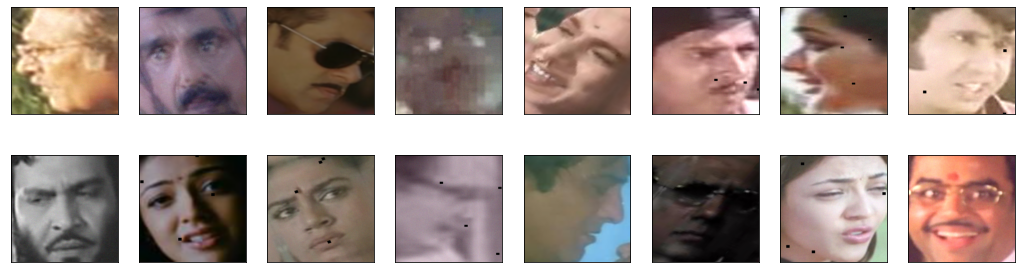

In [20]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def im_show(img):
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
fig = plt.figure(figsize=(18,5))

for i in np.arange(16):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    im_show(img[i])
    

TRAINING

trained_model with weights saved 

In [0]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('start time: {:10f} minutes'.format((time.time())/60))
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    start_time = time.time()
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}
    valid_epoch_loss=999
    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step(valid_epoch_loss)
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += (loss.data).item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = float(running_loss) / dataset_sizes[phase]
                train_epoch_acc = float(running_corrects) / dataset_sizes[phase]
            else:
                valid_epoch_loss = float(running_loss) / dataset_sizes[phase]
                valid_epoch_acc = float(running_corrects) / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(),'./checkpoint/current_checkpoint.pt')
        print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

used efficientnetb5

In [21]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

TRAINED LAST LAYER- 5epochs  (4 should be better)

In [23]:
model = EfficientNet.from_pretrained('efficientnet-b5')
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# new final layer with 16 classes
in_features = model._fc.in_features
classifier =nn.Linear(in_features, 3)
                           
model._fc=classifier
if torch.cuda.is_available():
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer =Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

dataloaders = {'train':trainloader, 'valid':valloader}

Loaded pretrained weights for efficientnet-b5


In [24]:
from tqdm import tqdm
from tqdm import tqdm_notebook
start_time = time.time()
model = train_model( dataloaders,model, criterion, optimizer, lr_scheduler, num_epochs=5)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

start time: 26504417.162705 minutes


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Training time:   5.331530 minutes
Epoch [0/4] train loss: 0.9242 acc: 0.5742 valid loss: 0.8568 acc: 0.6438
Training time:  10.623521 minutes
Epoch [1/4] train loss: 0.8601 acc: 0.6122 valid loss: 0.8157 acc: 0.6493
Training time:  15.878428 minutes
Epoch [2/4] train loss: 0.8533 acc: 0.6162 valid loss: 0.7928 acc: 0.6599
Training time:  21.110589 minutes
Epoch [3/4] train loss: 0.8523 acc: 0.6153 valid loss: 0.7894 acc: 0.6609
Training time:  26.333290 minutes
Epoch [4/4] train loss: 0.8522 acc: 0.6180 valid loss: 0.7944 acc: 0.6551
Best val Acc: 0.660889
Training time:  26.334607 minutes


TRAINED ALL LAYERS- 10 epochs  (will try more epochs later)

In [25]:
model = EfficientNet.from_pretrained('efficientnet-b5')

# freeze all model parameters
for param in model.parameters():
    param.requires_grad = True

# new final layer with 16 classes
in_features = model._fc.in_features
classifier =nn.Linear(in_features, 3)
                           
model._fc=classifier
model.load_state_dict(torch.load('./checkpoint/current_checkpoint.pt'),strict=True)

if torch.cuda.is_available():
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer =Over9000(model.parameters(), lr=1e-3, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

dataloaders = {'train':trainloader, 'valid':valloader}

Loaded pretrained weights for efficientnet-b5


In [26]:
start_time = time.time()
model = train_model( dataloaders,model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

start time: 26504448.377935 minutes
Training time:  12.873933 minutes
Epoch [0/9] train loss: 0.7207 acc: 0.6913 valid loss: 0.5101 acc: 0.7985
Training time:  25.639430 minutes
Epoch [1/9] train loss: 0.5153 acc: 0.7874 valid loss: 0.3943 acc: 0.8430
Training time:  38.413854 minutes
Epoch [2/9] train loss: 0.3903 acc: 0.8412 valid loss: 0.3549 acc: 0.8583
Training time:  51.089673 minutes
Epoch [3/9] train loss: 0.3015 acc: 0.8787 valid loss: 0.3475 acc: 0.8706
Training time:  63.962995 minutes
Epoch [4/9] train loss: 0.2359 acc: 0.9113 valid loss: 0.3422 acc: 0.8769
Training time:  76.697085 minutes
Epoch [5/9] train loss: 0.1986 acc: 0.9250 valid loss: 0.4885 acc: 0.8189
Training time:  89.501550 minutes
Epoch [6/9] train loss: 0.1539 acc: 0.9414 valid loss: 0.3666 acc: 0.8847
Training time: 102.337586 minutes
Epoch [7/9] train loss: 0.1327 acc: 0.9507 valid loss: 0.3617 acc: 0.8890
Training time: 115.077028 minutes
Epoch [8/9] train loss: 0.1098 acc: 0.9595 valid loss: 0.3825 acc:

TRAINED LAST LAYER- 4 epochs

In [39]:
model = EfficientNet.from_pretrained('efficientnet-b5')

# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# new final layer with 16 classes
in_features = model._fc.in_features
classifier =nn.Linear(in_features, 3)
                           
model._fc=classifier
model.load_state_dict(torch.load('./checkpoint/current_checkpoint.pt'),strict=True)

if torch.cuda.is_available():
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer =Over9000(model.parameters(), lr=1e-3, weight_decay=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

dataloaders = {'train':trainloader, 'valid':valloader}

Loaded pretrained weights for efficientnet-b5


In [40]:
start_time = time.time()
model = train_model( dataloaders,model, criterion, optimizer, exp_lr_scheduler, num_epochs=4)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

start time: 26504578.484846 minutes
Training time:   5.290921 minutes
Epoch [0/3] train loss: 0.1093 acc: 0.9613 valid loss: 0.3290 acc: 0.9030
Training time:  10.567391 minutes
Epoch [1/3] train loss: 0.0992 acc: 0.9651 valid loss: 0.3190 acc: 0.9050
Training time:  15.797041 minutes
Epoch [2/3] train loss: 0.0907 acc: 0.9673 valid loss: 0.3197 acc: 0.9040
Training time:  21.075119 minutes
Epoch [3/3] train loss: 0.0883 acc: 0.9685 valid loss: 0.3236 acc: 0.9050
Best val Acc: 0.905049
Training time:  21.076473 minutes


In [0]:
output=sample_submission[['ID','Class']]

In [42]:
output.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,MIDDLE
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,MIDDLE


In [0]:
testdata=test_Age(output)

In [0]:
testloader=DataLoader(testdata,batch_size=16)

In [0]:
def test_submission(model):
    since = time.time()
    sub_output = []
    model.train(False)
    for data in testloader:
        inputs,labels = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        pred = pred.data.cpu().numpy()
        sub_output.append(pred.data)
    sub_output = np.concatenate(sub_output)
    output['Class'] = sub_output
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [46]:
test_submission(model)


Run complete in 0m 55s


In [47]:
output.head()

,ID,Class
0,25321.jpg,1
1,989.jpg,0
2,19277.jpg,1
3,13093.jpg,2
4,5367.jpg,1


In [0]:
submission=output[['ID','Class']]

In [0]:
submission=submission.replace(0,'YOUNG')
submission=submission.replace(1,'MIDDLE')
submission=submission.replace(2,'OLD')



In [0]:
submission.to_csv('SUBMISSION3(2).csv',index=False)